# Simple nn for real circles ( based on [this article](https://towardsdatascience.com/object-detection-with-neural-networks-a4e2c46b4491) and [this tutorial](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py) )

In [1]:
%cd ..

/mnt/s/Keep working hard/projects/python/farich-pics


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from farichlib.DataPreprocessing import DataPreprocessing
%matplotlib inline

Start

In [5]:
dp = DataPreprocessing()
# dp.parse_root('data/farichSimRes_pi-kaon-_1000MeV_0-90deg_50.0k_2020-02-11.root')

In [6]:
dp.parse_pickle('data/pik0.pkl')

In [254]:
imgs, y = dp.get_images()

In [255]:
for i,j in zip(imgs, y):
    roll_mat(i,j) 

In [253]:
def roll_mat(img, y):
    sx, sy = img.shape
#     img = img.copy()
#     y = y.copy()
    x_shift = random.randint(-10, 10)
    y_shift = random.randint(-20, 40)
    img.row = np.remainder(img.row + x_shift, sx)
    img.col = np.remainder(img.col + y_shift, sy)
    
    y[0] += x_shift
    y[1] += y_shift
    return# [img, y]

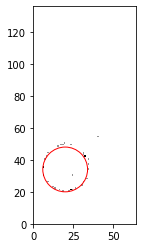

In [258]:
i = 44
img, bbox = imgs[i], y[i]
img = img.toarray()
plt.imshow(img.T, cmap='Greys', interpolation='none', origin='lower', 
           extent=[0, imgs[i].shape[0], 0, imgs[i].shape[1]])
# bbox = y[i]
plt.gca().add_patch(matplotlib.patches.Circle((bbox[0], bbox[1]), bbox[2], ec='r', fc='none'))

In [259]:
imgs[0].shape

(64, 136)

In [260]:
def getXtraintest():
    part = int(0.8*len(imgs))
    iTrain = np.concatenate( [np.ones(len(imgs[i].row))*i for i in range(part)] ).astype(int)
    iTest = np.concatenate( [np.ones(len(imgs[i].row))*(i-part) for i in range(part, len(imgs))] ).astype(int)
    i = np.concatenate( [iTrain, iTest] )
    x = np.concatenate( [img.row for img in imgs]  )
    y = np.concatenate( [img.col for img in imgs]  )
    
    ind = torch.LongTensor(np.vstack((i, x, y)))
    val = torch.FloatTensor( np.ones(len(i)) )
    
    X_train = torch.sparse.FloatTensor(ind[:,:len(iTrain)], val[:len(iTrain)], torch.Size([part, 64, 136]))
    X_test  = torch.sparse.FloatTensor(ind[:,len(iTrain):], val[len(iTrain):], torch.Size([len(imgs)-part, 64, 136]))
    
    X_train = X_train.unsqueeze(1)
    X_test  = X_test.unsqueeze(1)
    return X_train, X_test
    

In [261]:
X_train, X_test = getXtraintest()

In [262]:
X_test.shape

torch.Size([5102, 1, 64, 136])

In [263]:
# Normalize x, y, w, h by img_size
# y = у / img_size
y.shape, np.mean(y), np.std(y)

((25508, 3), 31.30091213214155, 17.38333927949254)

In [264]:
# Split training and test.
i = int(0.8 * len(imgs))
# X_train = X[:i]
# X_test = X[i:]
y_train = y[:i]
y_test = y[i:]
test_imgs = imgs[i:]
# test_bboxes = bboxes[i:]

In [265]:
X_train.shape

torch.Size([20406, 1, 64, 136])

In [266]:
y_train.shape

(20406, 3)

In [267]:
# Use torch data format
# X_train = torch.FloatTensor(X_train).unsqueeze(1) #Add one dimension to the tensor
# X_test  = torch.FloatTensor(X_test).unsqueeze(1)

y_train = torch.FloatTensor(y_train)
y_test  = torch.FloatTensor(y_test)

In [268]:
X_test.shape

torch.Size([5102, 1, 64, 136])

In [269]:
y_test.shape

torch.Size([5102, 3])

In [270]:
import torch
from torch import nn
import torch.nn.functional as F

In [271]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 10, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear( 4480, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


model = Net()
print(model)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 10, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=4480, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)


In [275]:
params = list(model.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 3, 3])


In [276]:
# Check that network passes data
input = torch.randn(1, 1, 64, 136)
out = model(input)

In [277]:
out

tensor([[-0.0063,  0.0051, -0.1522]], grad_fn=<AddmmBackward>)

In [415]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), 1e-2) #Adam

In [279]:
X_train = X_train.to_dense()
X_test = X_test.to_dense()

In [280]:
X_test[:2].shape

torch.Size([2, 1, 64, 136])

In [282]:
permutation = torch.randperm(X_train.size()[0])

In [314]:
batch_size = 100
num_train = X_train.size()[0]
num_test = X_test.size()[0]
train_losses = []
test_losses = []

In [407]:
def train(num_epoch):
    for i in range(num_epoch): 
        perm_train = torch.randperm(num_train)
        model.train(True)
        for j in range(0, num_train, batch_size):
            indices = perm_train[i:i+batch_size]
            X_batch, y_batch = X_train[indices], y_train[indices]
            
            #Loss
            y_pred = model(X_batch)
            train_loss = loss_fn(y_pred, y_batch)
            train_losses.append( float(train_loss) )
            #zero grad
            optimizer.zero_grad()
            #back prop
            train_loss.backward()
            #update weigths
            optimizer.step()

            model.train(False)
            
            test_check = np.random.randint(0, len(y_test), 40)
            y_pred = model(X_test[test_check])
            test_loss = loss_fn(y_pred, y_test[test_check])
            test_losses.append( float(test_loss) )

            train_l = float(train_loss)
            test_l = float(test_loss)
            if j%1000==0:
                print(f'Epoch {i}:{j//batch_size} | Train loss: {train_l:.4f}; Test loss: {test_l:.4f}',)

    return

In [416]:
train(1)

Epoch 0:0 | Train loss: 119.6942; Test loss: 122.3263
Epoch 0:1 | Train loss: 119.6551; Test loss: 127.5492
Epoch 0:2 | Train loss: 119.6169; Test loss: 118.7976
Epoch 0:3 | Train loss: 119.5799; Test loss: 131.4726
Epoch 0:4 | Train loss: 119.5438; Test loss: 148.0735
Epoch 0:5 | Train loss: 119.5086; Test loss: 138.0058
Epoch 0:6 | Train loss: 119.4744; Test loss: 119.0042
Epoch 0:7 | Train loss: 119.4411; Test loss: 118.9938
Epoch 0:8 | Train loss: 119.4086; Test loss: 133.9864
Epoch 0:9 | Train loss: 119.3771; Test loss: 109.2825
Epoch 0:10 | Train loss: 119.3463; Test loss: 113.5063
Epoch 0:11 | Train loss: 119.3164; Test loss: 110.2639
Epoch 0:12 | Train loss: 119.2874; Test loss: 137.9814
Epoch 0:13 | Train loss: 119.2590; Test loss: 114.2148
Epoch 0:14 | Train loss: 119.2314; Test loss: 128.5371
Epoch 0:15 | Train loss: 119.2045; Test loss: 112.0212
Epoch 0:16 | Train loss: 119.1783; Test loss: 117.8723
Epoch 0:17 | Train loss: 119.1529; Test loss: 108.1036
Epoch 0:18 | Train l

Epoch 0:149 | Train loss: 118.2440; Test loss: 106.7205
Epoch 0:150 | Train loss: 118.2433; Test loss: 98.9680
Epoch 0:151 | Train loss: 118.2426; Test loss: 132.5930
Epoch 0:152 | Train loss: 118.2419; Test loss: 115.6693
Epoch 0:153 | Train loss: 118.2413; Test loss: 99.8761
Epoch 0:154 | Train loss: 118.2406; Test loss: 128.6995
Epoch 0:155 | Train loss: 118.2399; Test loss: 100.8500
Epoch 0:156 | Train loss: 118.2393; Test loss: 105.8255
Epoch 0:157 | Train loss: 118.2388; Test loss: 136.8861
Epoch 0:158 | Train loss: 118.2382; Test loss: 120.9909
Epoch 0:159 | Train loss: 118.2376; Test loss: 111.0072
Epoch 0:160 | Train loss: 118.2371; Test loss: 113.3349
Epoch 0:161 | Train loss: 118.2365; Test loss: 128.6820
Epoch 0:162 | Train loss: 118.2360; Test loss: 110.0052
Epoch 0:163 | Train loss: 118.2355; Test loss: 103.8209
Epoch 0:164 | Train loss: 118.2350; Test loss: 102.3493
Epoch 0:165 | Train loss: 118.2345; Test loss: 144.6866
Epoch 0:166 | Train loss: 118.2340; Test loss: 125

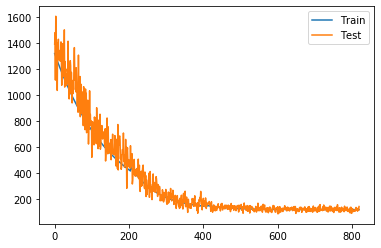

In [423]:
plot_train = train_losses[:]
plot_test  = test_losses[:]
plt.plot(range(len(plot_train)), plot_train, label='Train')
plt.plot(range(len(plot_test)), plot_test, label='Test')
plt.legend()

In [418]:
test_check = np.random.randint(0, len(y_test), 10)
y_pred = model(X_test[test_check])

In [419]:
# AS TWO SQUARES
def IOU(bbox1, bbox2):
    x1, y1, w1 = bbox1[0], bbox1[1], 2*bbox1[2]
    x2, y2, w2 = bbox2[0], bbox2[1], 2*bbox2[2]
    x1, y1, x2, y2 = x1-w1, y1-w1, x2-w2, y2-w2

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + w1, y2 + w2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I

    U = w1 * w1 + w2 * w2 - I

    return I / U

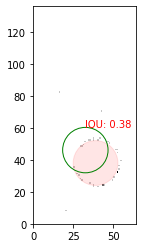

In [420]:
import random
i = random.randint(0, len(test_check)-1)
img = X_test[i][0].numpy()
exp_box = y_test[i].numpy()
pred_box = y_pred[i].detach().numpy()
plt.imshow(img.T, cmap='Greys', interpolation='none', origin='lower', 
           extent=[0, img.shape[0], 0, img.shape[1]])
plt.gca().add_patch(matplotlib.patches.Circle((exp_box[0], exp_box[1]), exp_box[2], ec='r', fc='red', alpha=0.1))
plt.gca().add_patch(matplotlib.patches.Circle((pred_box[0], pred_box[1]), pred_box[2], ec='g', fc='none'))
plt.annotate('IOU: {:.2f}'.format(IOU(pred_box, exp_box)), (pred_box[0], pred_box[1]+pred_box[2]+0.2), color='r');

In [421]:
pred_bboxes = y_pred.detach().numpy()
test_bboxes = y_test.numpy()

In [422]:
summed_IOU = 0.
for pred_bbox, test_bbox in zip(pred_bboxes, test_bboxes):
    summed_IOU += IOU(pred_bbox, test_bbox)
mean_IOU = summed_IOU / len(pred_bboxes)
mean_IOU

0.2580322049225413